# Analysis on H-1B dataset 

# Merge Database

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import numpy
from datetime import datetime
style.use('ggplot')

All dataset is in .xlsm format. Use Excel to save it as csv and use pandas read csv function. Set the Case Number as index

In [2]:
dataset2014 = pd.read_csv('H-1B_FY14_Q4.csv', index_col = 0, dtype= {'EMPLOYER_PHONE':str,'EMPLOYER_PHONE_EXT':str}, skipinitialspace=True)
dataset2015 = pd.read_csv('H-1B_Disclosure_Data_FY15_Q4.csv', index_col = 0, dtype= {'EMPLOYER_PHONE':str,'EMPLOYER_PHONE_EXT':str}, skipinitialspace=True)
dataset2016 = pd.read_csv('H-1B_Disclosure_Data_FY16.csv', index_col = 0, dtype= {'EMPLOYER_PHONE':str,'EMPLOYER_PHONE_EXT':str},skipinitialspace=True)

Some columns are placed with different names in the three datasets. Change dataset2014 and 2015 column headers and match with dataset2016

In [3]:
dataset2014.rename(columns={'STATUS':'CASE_STATUS','LCA_CASE_SUBMIT':'CASE_SUBMITTED','LCA_CASE_EMPLOYMENT_START_DATE':'EMPLOYMENT_START_DATE',
                           'LCA_CASE_EMPLOYMENT_END_DATE':'EMPLOYMENT_END_DATE','LCA_CASE_EMPLOYER_NAME':'EMPLOYER_NAME','LCA_CASE_EMPLOYER_CITY':'EMPLOYER_CITY',
                           'LCA_CASE_EMPLOYER_STATE':'EMPLOYER_STATE','LCA_CASE_JOB_TITLE':'JOB_TITLE','LCA_CASE_SOC_CODE':'SOC_CODE',
                           'LCA_CASE_SOC_NAME':'SOC_NAME','FULL_TIME_POS':'FULL_TIME_POSITION','PW_1':'PREVAILING_WAGE','PW_UNIT_1':'PW_UNIT_OF_PAY',
                           'LCA_CASE_WORKLOC1_CITY':'WORKSITE_CITY','LCA_CASE_WORKLOC1_STATE':'WORKSITE_STATE','LCA_CASE_WAGE_RATE_FROM':'WAGE_RATE_OF_PAY_FROM',
                           'LCA_CASE_WAGE_RATE_UNIT':'WAGE_UNIT_OF_PAY'}, inplace = True)
dataset2015.rename(columns={'TOTAL WORKERS':'TOTAL_WORKERS'}, inplace=True)

In dataset2015, the employee wage is in one column in a range. Seperate it with split function

In [4]:
dataset2015['WAGE_RATE_OF_PAY_FROM'] = dataset2015['WAGE_RATE_OF_PAY'].str.split('-').str[0]

In [5]:
frames = [dataset2014,dataset2015,dataset2016]
totaldf = pd.concat(frames)

Delete all unnessary columns

In [6]:
totaldf = totaldf.drop(['EMPLOYER_ADDRESS','EMPLOYER_ADDRESS1','EMPLOYER_ADDRESS2','EMPLOYER_POSTAL_CODE','EMPLOYER_PROVINCE',
                        'EMPLOYER_COUNTRY','EMPLOYER_PHONE','EMPLOYER_PHONE_EXT','NAIC_CODE','FULL_TIME_POSITION',
                        'PW_WAGE_SOURCE','PW_SOURCE_YEAR','PW_SOURCE_OTHER','WORKSITE_POSTAL_CODE','LCA_CASE_EMPLOYER_ADDRESS',
                        'LCA_CASE_NAICS_CODE','OTHER_WAGE_SOURCE_1','OTHER_WAGE_SOURCE_2','PW_SOURCE_1','PW_SOURCE_2','PW_UNIT_2', 'PW_2',
                        'LCA_CASE_EMPLOYER_POSTAL_CODE','LCA_CASE_WORKLOC2_CITY','LCA_CASE_WORKLOC2_STATE','YR_SOURCE_PUB_1',
                        'YR_SOURCE_PUB_2','WILLFUL VIOLATOR','WILLFUL_VIOLATOR','AGENT_ATTORNEY_CITY','AGENT_ATTORNEY_NAME','AGENT_ATTORNEY_STATE',
                        'SOC_CODE','ORIGINAL_CERT_DATE','PREVAILING_WAGE','PW_UNIT_OF_PAY','WAGE_RATE_OF_PAY','WORKSITE_CITY','EMPLOYER_CITY','H-1B_DEPENDENT','PW_WAGE_LEVEL','PW_WAGE_SOURCE_OTHER','WAGE_RATE_OF_PAY_TO','WORKSITE_COUNTY','PW_WAGE_SOURCE_YEAR','LCA_CASE_WAGE_RATE_TO'],axis = 1)

In [7]:
print(totaldf.columns.values)

['CASE_STATUS' 'CASE_SUBMITTED' 'DECISION_DATE' 'EMPLOYER_NAME'
 'EMPLOYER_STATE' 'EMPLOYMENT_END_DATE' 'EMPLOYMENT_START_DATE' 'JOB_TITLE'
 'SOC_NAME' 'TOTAL_WORKERS' 'VISA_CLASS' 'WAGE_RATE_OF_PAY_FROM'
 'WAGE_UNIT_OF_PAY' 'WORKSITE_STATE']


The following columns will be used for analysis

# Dealing Missing Data

General View for missing data

In [8]:
print('Total Rows in dataframe : ',totaldf.shape[0])
for columns in totaldf:
    print(columns, ' : ', totaldf[columns].isnull().sum())

Total Rows in dataframe :  1786160
CASE_STATUS  :  0
CASE_SUBMITTED  :  0
DECISION_DATE  :  0
EMPLOYER_NAME  :  66
EMPLOYER_STATE  :  123
EMPLOYMENT_END_DATE  :  49
EMPLOYMENT_START_DATE  :  40
JOB_TITLE  :  34
SOC_NAME  :  4295
TOTAL_WORKERS  :  18
VISA_CLASS  :  0
WAGE_RATE_OF_PAY_FROM  :  36
WAGE_UNIT_OF_PAY  :  76
WORKSITE_STATE  :  86


The simpliest way to deal with missing data is to delete all missing rows with missing data.

In [9]:
droptotaldf = totaldf.dropna(axis=0)

In [10]:
print('Total Rows in dataframe : ',droptotaldf.shape[0])
for columns in droptotaldf:
    print(columns, ' : ', droptotaldf[columns].isnull().sum())

Total Rows in dataframe :  1781637
CASE_STATUS  :  0
CASE_SUBMITTED  :  0
DECISION_DATE  :  0
EMPLOYER_NAME  :  0
EMPLOYER_STATE  :  0
EMPLOYMENT_END_DATE  :  0
EMPLOYMENT_START_DATE  :  0
JOB_TITLE  :  0
SOC_NAME  :  0
TOTAL_WORKERS  :  0
VISA_CLASS  :  0
WAGE_RATE_OF_PAY_FROM  :  0
WAGE_UNIT_OF_PAY  :  0
WORKSITE_STATE  :  0


Generally, for dataset like this. Removing 5000 rows will not affect the accuracy much 

# Common Units

In the dataset, there are some salary are displayed as Hour, Bi-Weekly, Month and Week instead of Year. All salary now is stored in a new column yearlywage

In [12]:
def yearlywage(row):
    #some wages is in string format, if found will convert to float for futher calculations
    if type(row['WAGE_RATE_OF_PAY_FROM'])== str:
        row['WAGE_RATE_OF_PAY_FROM'] = row['WAGE_RATE_OF_PAY_FROM'].replace(",", "")
        row['WAGE_RATE_OF_PAY_FROM'] = float(row['WAGE_RATE_OF_PAY_FROM'])
    if row['WAGE_UNIT_OF_PAY'] == 'Month':
        val = row['WAGE_RATE_OF_PAY_FROM'] *12
    elif row['WAGE_UNIT_OF_PAY'] == 'Bi-Weekly':
        val = row['WAGE_RATE_OF_PAY_FROM'] *26
    elif row['WAGE_UNIT_OF_PAY'] == 'Week':
        val = row['WAGE_RATE_OF_PAY_FROM'] *52
    elif row['WAGE_UNIT_OF_PAY'] == 'Hour':
        val = row['WAGE_RATE_OF_PAY_FROM'] *250
    else: val = row['WAGE_RATE_OF_PAY_FROM']
    return val
droptotaldf['yearlywage'] = droptotaldf.apply(yearlywage, axis = 1)

C:\Users\Herru\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [13]:
droptotaldf.loc[droptotaldf['WAGE_UNIT_OF_PAY'] == 'Year']

,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYMENT_END_DATE,EMPLOYMENT_START_DATE,JOB_TITLE,SOC_NAME,TOTAL_WORKERS,VISA_CLASS,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_STATE,yearlywage
I-200-09106-546545,CERTIFIED-WITHDRAWN,18/01/2013,29/09/2014,TEXAS STATE UNIVERSITY-SAN MARCOS,TX,01/02/2016,01/02/2013,POSTDOCTORAL RESEARCH ASSOCIATE,"Biological Scientists, All Other",1.0,H-1B,50000,Year,TX,50000.00
I-200-09162-143337,CERTIFIED,17/03/2014,21/03/2014,"EYE SPECIALISTS OF INDIANA, P.C.",IN,15/09/2017,15/09/2014,OPTOMETRIST,Optometrists,1.0,H-1B,65000,Year,IN,65000.00
I-200-09182-550211,DENIED,14/03/2014,20/03/2014,"LHB, INC.",MN,01/04/2015,01/04/2014,FOOD SAFETY SCIENTIST,Actors,1.0,H-1B,50000,Year,WI,50000.00
I-200-09193-873099,CERTIFIED,01/03/2014,06/03/2014,"WAM USA, INC.",GA,27/08/2017,28/08/2014,INTERNATIONAL ACCOUNTANT,Accountants and Auditors,1.0,H-1B,48000,Year,GA,48000.00
I-200-09197-120609,CERTIFIED-WITHDRAWN,10/03/2014,17/03/2014,"DFUSE TECHNOLOGIES, INC.",VA,01/09/2017,01/09/2014,PROGRAMMER ANALYST,Computer Programmers,1.0,H-1B,62000,Year,CA,62000.00
I-200-09203-855998,CERTIFIED,20/08/2014,26/08/2014,TAKE ENTERPRISE SERVICES INC,NJ,14/09/2015,20/08/2014,PROGRAMMER ANALYST,Computer Programmers,1.0,H-1B,69742,Year,NC,69742.00
I-200-09205-703458,WITHDRAWN,15/09/2014,15/09/2014,"TAKE SOLUTIONS, INC",NJ,10/01/2015,15/09/2014,PROGRAMMER ANLYST,Computer Programmers,1.0,H-1B,63000,Year,IL,63000.00
I-200-09205-927162,CERTIFIED,26/06/2014,02/07/2014,"PLATTFORM ADVERTISING, INC.",KS,11/10/2017,12/10/2014,SENIOR APPLICATION DEVELOPER,"Software Developers, Applications",1.0,H-1B,99403,Year,KS,99403.00
I-200-09208-457486,WITHDRAWN,17/07/2013,18/03/2014,PROPEL CORP.,KY,04/08/2012,05/08/2009,SOFTWARE ENGINEER,"Computer Software Engineers, Applications",1.0,H-1B,60000,Year,KY,60000.00
I-200-09211-513022,CERTIFIED-WITHDRAWN,30/07/2009,13/05/2014,UT HEALTH SCIENCE CENTER AT SAN ANTONIO,TX,14/09/2012,15/09/2009,ASSISTANT PROFESSOR,"Physicians and Surgeons, All Other",1.0,H-1B,190000,Year,TX,190000.00


In [14]:
droptotaldf.loc[droptotaldf['WAGE_UNIT_OF_PAY'] == 'Month']

,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYMENT_END_DATE,EMPLOYMENT_START_DATE,JOB_TITLE,SOC_NAME,TOTAL_WORKERS,VISA_CLASS,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_STATE,yearlywage
I-200-11088-934959,CERTIFIED-WITHDRAWN,29/03/2011,31/10/2013,CALIFORNIA DEPARTMENT OF TRANSPORTATION,CA,24/09/2014,25/09/2011,"TRANSPORTATION ENGINEER, CIVIL",Civil Engineers,1.0,H-1B,6413,Month,CA,76956.00
I-200-11117-138039,CERTIFIED-WITHDRAWN,28/04/2011,19/12/2013,"THE GREEN FRAME, INC.",NY,14/06/2014,15/06/2011,SITE PLANNER (LANDSCAPE ARCHITECT),Landscape Architects,1.0,H-1B,4500,Month,NY,54000.00
I-200-11130-641552,CERTIFIED-WITHDRAWN,10/05/2011,26/03/2014,TENNANT COMPANY,MN,10/07/2014,11/07/2011,SAP BUSINESS ANALYST IV,Computer Systems Analysts,1.0,H-1B,7255.75,Month,MN,87069.00
I-200-11180-171283,CERTIFIED-WITHDRAWN,29/06/2011,31/01/2014,THE UNIVERSITY OF HOUSTON,TX,31/07/2014,01/08/2011,ASSISTANT PROFESSOR,"Architecture Teachers, Postsecondary",1.0,H-1B,8333.33,Month,TX,99999.96
I-200-11264-547687,CERTIFIED-WITHDRAWN,22/09/2011,02/09/2014,HARMONY SCIENCE ACADEMY-NORTH AUSTIN,TX,01/10/2014,03/10/2011,ASSISTANT PRINCIPAL,"Education Administrators, Elementary and Secon...",1.0,H-1B,5000,Month,TX,60000.00
I-200-11265-991993,CERTIFIED-WITHDRAWN,22/09/2011,25/04/2014,HARMONY SCIENCE ACADEMY-EULESS,TX,15/10/2014,17/10/2011,RUSSIAN LANGUAGE TEACHER,"Secondary School Teachers, Except Special and ...",1.0,H-1B,3775,Month,TX,45300.00
I-200-11277-676450,CERTIFIED-WITHDRAWN,04/10/2011,02/06/2014,HARMONY SCIENCE ACADEMY-DALLAS,TX,12/11/2014,15/11/2011,ASSISTANT PRINCIPAL,"Education Administrators, Elementary and Secon...",1.0,H-1B,5166.66,Month,TX,61999.92
I-200-11292-843099,CERTIFIED-WITHDRAWN,19/10/2011,25/04/2014,HARMONY SCHOOL OF DISCOVERY,TX,29/11/2014,30/11/2011,ESL TEACHER,"Secondary School Teachers, Except Special and ...",1.0,H-1B,3800,Month,TX,45600.00
I-200-11301-474842,CERTIFIED-WITHDRAWN,28/10/2011,25/04/2014,HARMONY SCIENCE ACADEMY-EL PASO,TX,30/10/2014,01/11/2011,SCIENCE TEACHER,"Secondary School Teachers, Except Special and ...",1.0,H-1B,3750,Month,TX,45000.00
I-200-11305-797578,CERTIFIED-WITHDRAWN,01/11/2011,28/04/2014,DOVE SCIENCE ACADEMY-TULSA,OK,13/12/2014,14/12/2011,COMPUTER TEACHER,"Secondary School Teachers, Except Special and ...",1.0,H-1B,2975,Month,OK,35700.00


# Sanity Check

Clear out all duplicate indeies

In [15]:
droptotaldf = droptotaldf.groupby(droptotaldf.index).first()

In [16]:
print(droptotaldf.shape)

(1744428, 15)


In [17]:
print(droptotaldf.head())

                            CASE_STATUS CASE_SUBMITTED DECISION_DATE  \
I-200-09106-546545  CERTIFIED-WITHDRAWN     18/01/2013    29/09/2014   
I-200-09121-701936            WITHDRAWN     05/02/2015    05/02/2015   
I-200-09131-859003            CERTIFIED     10/03/2016    16/03/2016   
I-200-09146-796321            CERTIFIED     12/12/2014    18/12/2014   
I-200-09162-143337            CERTIFIED     17/03/2014    21/03/2014   

                                        EMPLOYER_NAME EMPLOYER_STATE  \
I-200-09106-546545  TEXAS STATE UNIVERSITY-SAN MARCOS             TX   
I-200-09121-701936                    MEDTRONIC, INC.             MN   
I-200-09131-859003                  POINT INSIDE INC.             WA   
I-200-09146-796321             UNIVERSITY OF OKLAHOMA             OK   
I-200-09162-143337   EYE SPECIALISTS OF INDIANA, P.C.             IN   

                   EMPLOYMENT_END_DATE EMPLOYMENT_START_DATE  \
I-200-09106-546545          01/02/2016            01/02/2013   
I-200-

Calculate the time of application from submittion to application

In the dataset, some dates is in American format (mm/dd/yyyy) and some is in (dd/mm/yyyy). The following code is turn all dates to (dd/mm/yyyy) for further analysis.

In [18]:
droptotaldf['EMPLOYMENT_START_DATE'] = pd.to_datetime(droptotaldf["EMPLOYMENT_START_DATE"],errors="coerce").dt.strftime("%d/%m/%Y")
droptotaldf['EMPLOYMENT_END_DATE'] = pd.to_datetime(droptotaldf["EMPLOYMENT_END_DATE"],errors="coerce").dt.strftime("%d/%m/%Y")                                                                                                           

In [19]:
droptotaldf[~droptotaldf.isin(['NaT']).any(axis=1)]

,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,EMPLOYER_NAME,EMPLOYER_STATE,EMPLOYMENT_END_DATE,EMPLOYMENT_START_DATE,JOB_TITLE,SOC_NAME,TOTAL_WORKERS,VISA_CLASS,WAGE_RATE_OF_PAY_FROM,WAGE_UNIT_OF_PAY,WORKSITE_STATE,yearlywage
I-200-09106-546545,CERTIFIED-WITHDRAWN,18/01/2013,29/09/2014,TEXAS STATE UNIVERSITY-SAN MARCOS,TX,02/01/2016,02/01/2013,POSTDOCTORAL RESEARCH ASSOCIATE,"Biological Scientists, All Other",1.0,H-1B,50000,Year,TX,50000.00
I-200-09121-701936,WITHDRAWN,05/02/2015,05/02/2015,"MEDTRONIC, INC.",MN,28/02/2015,09/02/2015,MECHANICAL ENGINEER,MECHANICAL ENGINEERS,1.0,H-1B,20000,Year,CA,20000.00
I-200-09131-859003,CERTIFIED,10/03/2016,16/03/2016,POINT INSIDE INC.,WA,09/01/2019,09/02/2016,"SOFTWARE ENGINEER, MAP SERVICES","SOFTWARE DEVELOPERS, APPLICATIONS",1.0,H-1B,"84,739.00",Year,WA,84739.00
I-200-09146-796321,CERTIFIED,12/12/2014,18/12/2014,UNIVERSITY OF OKLAHOMA,OK,04/01/2018,05/01/2015,ASSISTANT PROFESSOR,"ENGINEERING TEACHERS, POSTSECONDARY",1.0,H-1B,85000.00,Year,OK,85000.00
I-200-09162-143337,CERTIFIED,17/03/2014,21/03/2014,"EYE SPECIALISTS OF INDIANA, P.C.",IN,15/09/2017,15/09/2014,OPTOMETRIST,Optometrists,1.0,H-1B,65000,Year,IN,65000.00
I-200-09180-329758,WITHDRAWN,03/01/2013,15/12/2014,NOKIA INC.,TX,06/01/2016,07/01/2013,RELEASE AND SOFTWARE TEST MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER*",1.0,H-1B,94000,Year,CA,94000.00
I-200-09180-429413,CERTIFIED,04/03/2016,10/03/2016,"1NTEGER, LLC",CA,21/08/2019,22/08/2016,RESEARCH ANALYST,"FINANCIAL SPECIALISTS, ALL OTHER",2.0,H-1B,"41,808.00",Year,CA,41808.00
I-200-09182-550211,DENIED,14/03/2014,20/03/2014,"LHB, INC.",MN,04/01/2015,04/01/2014,FOOD SAFETY SCIENTIST,Actors,1.0,H-1B,50000,Year,WI,50000.00
I-200-09183-259985,CERTIFIED,10/03/2015,16/03/2015,"OMRON OILFIELD AND MARINE, INC.",TX,07/09/2018,07/09/2015,CONTROL ENGINEERING SPECIALIST,"ELECTRONICS ENGINEERS, EXCEPT COMPUTER",2.0,H-1B,66000,Year,TX,66000.00
I-200-09183-295355,CERTIFIED,11/03/2016,17/03/2016,"OMRON AUTOMOTIVE ELECTRONICS, INC.",IL,09/10/2019,09/10/2016,SOFTWARE DEVELOPMENT ENGINEER,"SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE",1.0,H-1B,"66,000.00",Year,MI,66000.00


Delete all missing datetime data

In [20]:
droptotaldf.replace(['NaT'], np.nan, inplace = True)
droptotaldf = droptotaldf.dropna()

Calculate the working days and application days and save in a new column

In [21]:
def employmentdaysbetween(row):
    date_format = "%d/%m/%Y"
    a = datetime.strptime(row['EMPLOYMENT_START_DATE'], date_format)
    b = datetime.strptime(row['EMPLOYMENT_END_DATE'], date_format)
    delta = b - a
    return delta.days

droptotaldf['employmentdays'] = droptotaldf.apply(employmentdaysbetween, axis = 1)

In [22]:
print('Minimum working day : ',droptotaldf['employmentdays'].min())
print('Maximum working day : ',droptotaldf['employmentdays'].max())

Minimum working day :  -1848
Maximum working day :  1826


In [23]:
def daysbetween(row):
    date_format = "%d/%m/%Y"
    a = datetime.strptime(row['CASE_SUBMITTED'], date_format)
    b = datetime.strptime(row['DECISION_DATE'], date_format)
    delta = b - a
    return delta.days

droptotaldf['applicationdays'] = droptotaldf.apply(daysbetween, axis = 1)

In [24]:
print('Minimum application day : ',droptotaldf['applicationdays'].min())
print('Maximum application day : ',droptotaldf['applicationdays'].max())

Minimum application day :  0
Maximum application day :  2367


As Employment date cannot be negative nor zero. All rows with employment date smaller or equal to zero will be removed

In [25]:
droptotaldf.drop(droptotaldf[droptotaldf.employmentdays <= 0].index, inplace=True)

In [26]:
print(droptotaldf.shape)
print('Minimum working day : ',droptotaldf['employmentdays'].min())
print('Maximum working day : ',droptotaldf['employmentdays'].max())

(1743161, 17)
Minimum working day :  1
Maximum working day :  1826


In [27]:
print(droptotaldf.head())

                            CASE_STATUS CASE_SUBMITTED DECISION_DATE  \
I-200-09106-546545  CERTIFIED-WITHDRAWN     18/01/2013    29/09/2014   
I-200-09121-701936            WITHDRAWN     05/02/2015    05/02/2015   
I-200-09131-859003            CERTIFIED     10/03/2016    16/03/2016   
I-200-09146-796321            CERTIFIED     12/12/2014    18/12/2014   
I-200-09162-143337            CERTIFIED     17/03/2014    21/03/2014   

                                        EMPLOYER_NAME EMPLOYER_STATE  \
I-200-09106-546545  TEXAS STATE UNIVERSITY-SAN MARCOS             TX   
I-200-09121-701936                    MEDTRONIC, INC.             MN   
I-200-09131-859003                  POINT INSIDE INC.             WA   
I-200-09146-796321             UNIVERSITY OF OKLAHOMA             OK   
I-200-09162-143337   EYE SPECIALISTS OF INDIANA, P.C.             IN   

                   EMPLOYMENT_END_DATE EMPLOYMENT_START_DATE  \
I-200-09106-546545          02/01/2016            02/01/2013   
I-200-

# Analysis

For the analysis part, I will use logistic regression to analysis

In [168]:
df = droptotaldf.copy()
df.drop(['EMPLOYER_NAME','JOB_TITLE','SOC_NAME','EMPLOYER_STATE','WORKSITE_STATE','CASE_SUBMITTED','DECISION_DATE','EMPLOYMENT_END_DATE','EMPLOYMENT_START_DATE','WAGE_RATE_OF_PAY_FROM','WAGE_UNIT_OF_PAY'],axis=1,inplace=True)
print(df.head())

                            CASE_STATUS  TOTAL_WORKERS VISA_CLASS  yearlywage  \
I-200-09106-546545  CERTIFIED-WITHDRAWN            1.0       H-1B     50000.0   
I-200-09121-701936            WITHDRAWN            1.0       H-1B     20000.0   
I-200-09131-859003            CERTIFIED            1.0       H-1B     84739.0   
I-200-09146-796321            CERTIFIED            1.0       H-1B     85000.0   
I-200-09162-143337            CERTIFIED            1.0       H-1B     65000.0   

                    employmentdays  applicationdays  
I-200-09106-546545            1095              619  
I-200-09121-701936              19                0  
I-200-09131-859003            1065                6  
I-200-09146-796321            1095                6  
I-200-09162-143337            1096                4  


As there are six cases in case status. Certified will be classified as 1 and other will be classified as -1

In [169]:
df['CASE_STATUS'] = df['CASE_STATUS'].replace('CERTIFIED',1)
df['CASE_STATUS'] = df['CASE_STATUS'].replace(['CERTIFIED-WITHDRAWN', 'WITHDRAWN', 'DENIED', 'REJECTED',
 'INVALIDATED'],-1)

In [170]:
df['VISA_CLASS'] = df['VISA_CLASS'].replace('H-1B',1)
df['VISA_CLASS'] = df['VISA_CLASS'].replace('H-1B1 Chile',2)    
df['VISA_CLASS'] = df['VISA_CLASS'].replace('H-1B1 Singapore',3)    
df['VISA_CLASS'] = df['VISA_CLASS'].replace('E-3 Australian',4)    

In [171]:
X = np.array(df.drop(['CASE_STATUS'],1))
y = np.array(df['CASE_STATUS'])

Remove Outlier

In [174]:
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

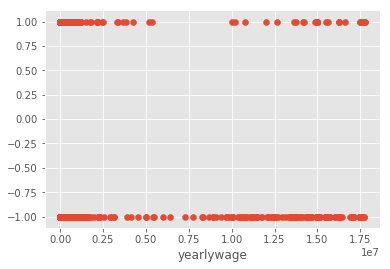

In [175]:
plt.scatter(df["yearlywage"], df["CASE_STATUS"])
plt.xlabel("yearlywage")
plt.show()


# Simple Logisitic Regression

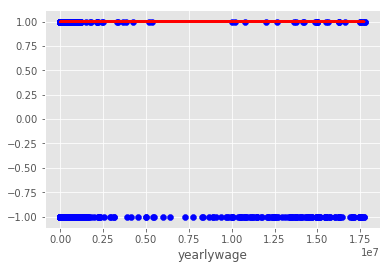

In [184]:
X = df[['yearlywage']]
y = df["CASE_STATUS"]
logmodel = LogisticRegression()
logmodel.fit(X, y)

plt.scatter(df["yearlywage"], df["CASE_STATUS"], color = 'b')
plt.plot(df["yearlywage"], logmodel.predict(X), color="r")
plt.xlabel("yearlywage")
plt.show()

# Classification Model

K-Nearest Neighbours

In [176]:
from sklearn import  preprocessing, neighbors
from sklearn.model_selection import train_test_split, cross_val_score

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)

In [178]:
clf= neighbors.KNeighborsClassifier()
scores = cross_val_score(clf,X_train, y_train, cv=10)
print("Cross Validation")
print(np.average(scores)*100,'%')

clf.fit(X_train,y_train)

accuracy = clf.score(X_test,y_test)
print('Accuracy')
print(accuracy*100,'%')

Cross Validation
95.433334487 %
Accuracy
95.4810124888 %


Logistic Regression

In [179]:
from sklearn.linear_model import LogisticRegression

In [180]:
model = LogisticRegression(penalty='l2', C=1)
result = model.fit(X_train,y_train)

In [181]:
scores = cross_val_score(model,X_train, y_train, cv=10)
print("Cross Validation")
print(np.average(scores)*100,'%')
accuracy = model.score(X_test,y_test)
print('Accuracy')
print(accuracy*100,'%')

Cross Validation
92.560552785 %
Accuracy
93.8391697852 %
